<a href="https://colab.research.google.com/github/shineloveyc/Doing_ML/blob/master/Bert_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bert tutorial
https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/

In [0]:
#the benchmark model for many NLP task
!pip install pytorch-pretrained-bert

     |████████████████████████████████| 133kB 2.9MB/s 


In [0]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

import logging

import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
#load the pre-trained model tokenizer (vocabulary)
#12-layer, 768-hidden, 12-heads, 110M parameters.Trained on lower-cased English text.
#https://huggingface.co/transformers/pretrained_models.html
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 6289608.58B/s]


Because BERT is a pretrained model that expects input data in a specific format, we will need:

* special tokens to mark the beginning ([CLS]) and separation/end of sentences ([SEP])
* tokens that conforms with the fixed vocabulary used in BERT
token IDs from BERT’s tokenizer
* mask IDs to indicate which elements in the sequence are tokens and which are padding elements
*segment IDs used to distinguish different sentences
positional embeddings used to show token position within the sequence

In [0]:
#test the tokenizer
text = "Here is the sentence I want to embedding for."

marked_text = "[CLS] " + text + " [SEP]"

tokenized_text = tokenizer.tokenize(marked_text)

print(tokenized_text)

['[CLS]', 'here', 'is', 'the', 'sentence', 'i', 'want', 'to', 'em', '##bed', '##ding', 'for', '.', '[SEP]']


Why does it look this way? This is because the BERT tokenizer was created with a WordPiece model. This model greedily creates a fixed-size vocabulary of individual characters, subwords, and words that best fits our language data. Since the vocabulary limit size of our BERT tokenizer model is 30,000, the WordPiece model generated a vocabulary that contains all English characters plus the ~30,000 most common words and subwords found in the English language corpus the model is trained on. This vocabulary contains four things:

* Whole words
* Subwords occuring at the front of a word or in isolation (“em” as in “embeddings” is assigned the same vector as the standalone sequence of characters “em” as in “go get em” )
* Subwords not at the front of a word, which are preceded by ‘##’ to denote this case
* Individual characters

To tokenize a word under this model, the tokenizer first checks if the whole word is in the vocabulary. If not, it tries to break the word into the largest possible subwords contained in the vocabulary, and as a last resort will decompose the word into individual characters. Note that because of this, we can always represent a word as, at the very least, the collection of its individual characters.

As a result, rather than assigning out of vocabulary words to a catch-all token like ‘OOV’ or ‘UNK,’ words that are not in the vocabulary are decomposed into subword and character tokens that we can then generate embeddings for.

In [0]:
#print the bert vocab
#Tokens beginning with two hashes are subwords or individual characters.
list(tokenizer.vocab.keys())[5000:5020]

['knight',
 'lap',
 'survey',
 'ma',
 '##ow',
 'noise',
 'billy',
 '##ium',
 'shooting',
 'guide',
 'bedroom',
 'priest',
 'resistance',
 'motor',
 'homes',
 'sounded',
 'giant',
 '##mer',
 '150',
 'scenes']

In [0]:
#After breaking the text into tokens, we then have to convert the sentence from a list of strings to a list of vocabulary indeces.
#map the token strings to their vocabulary indeces

# Define a new example sentence with multiple meanings of the word "bank"
text = "After stealing money from the bank vault, the bank robber was seen " \
       "fishing on the Mississippi river bank."

# Add the special tokens.
marked_text = "[CLS] " + text + " [SEP]"

# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(marked_text)

indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

for tup in zip(tokenized_text, indexed_tokens):
     print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
after         2,044
stealing     11,065
money         2,769
from          2,013
the           1,996
bank          2,924
vault        11,632
,             1,010
the           1,996
bank          2,924
robber       27,307
was           2,001
seen          2,464
fishing       5,645
on            2,006
the           1,996
mississippi   5,900
river         2,314
bank          2,924
.             1,012
[SEP]           102


### Segment ID

In [0]:
# use 1s and 0s to distinguish between the two sentences. if all tokens from first setences, then 0, from 2nd, then 1
#since the example is single sentence input, so all 1
segments_ids = [1] * len(tokenized_text)

print(segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


## Extracting Embeddings

In [0]:
#covert our data to tensor by using torch and call the BERT model
#convert input to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])

#convert segment to Pytorch tensors
segments_tensor = torch.tensor(segments_ids)

In [0]:
#load pre-trained model(weights)==>12 layers
model = BertModel.from_pretrained('bert-base-uncased')

100%|██████████| 407873900/407873900 [00:06<00:00, 67834574.41B/s]


In [0]:
#put the model in 'evaluation' mode, meaning feed-forward operations
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Lin

In [0]:
#predict hidden states features for each layer
with torch.no_grad():
  encoded_layers, _ = model(tokens_tensor, segments_tensor)

The full set of hidden states for this model, stored in the object encoded_layers, is a little dizzying. This object has four dimensions, in the following order:

* The layer number (12 layers)
* The batch number (1 sentence)
* The word / token number (22 tokens in our sentence)
* The hidden unit / feature number (768 features)
That’s 202,752 unique values just to represent our one sentence! 12*22*768

The second dimension, the batch size, is used when submitting multiple sentences to the model at once; here, though, we just have one example sentence.

![alt text](http://jalammar.github.io/images/bert-contexualized-embeddings.png)

In [0]:
print('Number of layers:', len(encoded_layers))
layer_i = 0

print("Number of batches:", len(encoded_layers[layer_i]))
batch_i = 0

print("number of tokens:", len(encoded_layers[layer_i][batch_i]))
token_i = 0

print("Number of hidden units:", len(encoded_layers[layer_i][batch_i][token_i]))

Number of layers: 12
Number of batches: 1
number of tokens: 22
Number of hidden units: 768


In [0]:
# check the 5th token in our setence, select its feature values from layer 5
token_i = 5,
layer = 5

vec = encoded_layers[layer_i][batch_i][token_i]

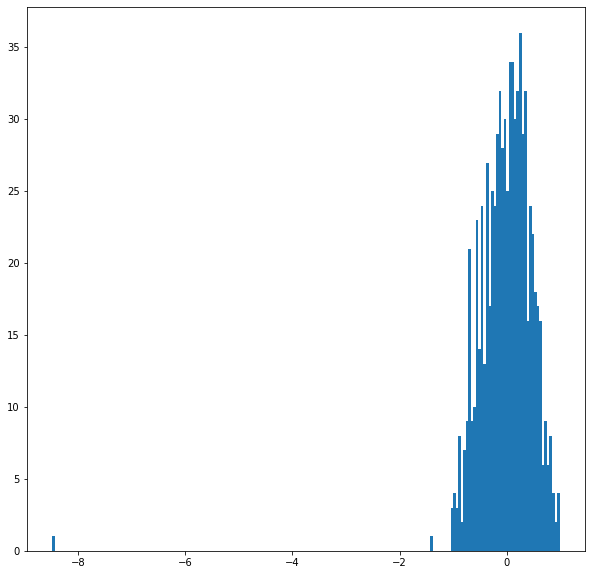

In [0]:
#plot the feature values as a histogram to show the distribution==> [-2, 2]
plt.figure(figsize=(10, 10))
plt.hist(vec, bins = 200)
plt.show()

In [0]:
# encoded layer is a python list
print(' type of encoded layer:', type(encoded_layers))

#each layers in the list is a torch tensor
print("tensore shape for each layer:", encoded_layers[0].size())

 type of encoded layer: <class 'list'>
tensore shape for each layer: torch.Size([1, 22, 768])


In [0]:
#combine the 12 layers to make one big tensore
token_embeddings = torch.stack(encoded_layers, dim = 0)

token_embeddings.size()

torch.Size([12, 1, 22, 768])

In [0]:
#get rid of batch dimension as there is only one setence
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()

torch.Size([12, 22, 768])

In [0]:
#swap dimensions 0 and 1

token_embeddings = token_embeddings.permute(1, 0, 2)

token_embeddings.size()

torch.Size([22, 12, 768])

### Create word and setence vectors from hidden states

In [0]:
#store the token vectors, with shape [22* 3072] 3072 = 4 * 768
token_vecs_cat = []

#for each token in the setence...
for token in token_embeddings:
  #token is a [12* 768] tensore
  # Concatenate the vectors (that is, append them together) from the last four layers.
  # Each layer vector is 768 values, so `cat_vec` is length 3,072.

  cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim = 0)
  token_vecs_cat.append(cat_vec)
  #used the 'cat_vec' to represent 'token'

print( 'Shape is %d * %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))

Shape is 22 * 3072


In [0]:
#store the token vectors with shape [22*768]

token_vecs_sum = []

for token in token_embeddings:
  #sum vector from the last four layers
  sum_vec= torch.sum(token[-4:], dim = 0)

  #use 'sum_vec' to represent 'token
  token_vecs_sum.append(sum_vec)

print('Shape is %d * %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))



Shape is 22 * 768


In [0]:
#get sentence vectors by average the second to last hidden layers of each token producing a single 768 vectors

token_vecs  = encoded_layers[11][0]

token_vecs.size()

setence_embedding = torch.mean(token_vecs, dim = 0)

print("Our final sentence embedding vector of shape:", setence_embedding.size(0))

Our final sentence embedding vector of shape: 768


#### Confirm contextually dependent vectors

In [0]:
# find index of three 'bank' in the example setence
for i, token_str in enumerate(tokenized_text):
  print( i , token_str)

0 [CLS]
1 after
2 stealing
3 money
4 from
5 the
6 bank
7 vault
8 ,
9 the
10 bank
11 robber
12 was
13 seen
14 fishing
15 on
16 the
17 mississippi
18 river
19 bank
20 .
21 [SEP]


In [0]:
#use word vectors by summing the last four layers and compare the 'bank'
#bank index 6, 10, 19
 print( 'First 5 vector values for each instance of "bank"')
 print('')
 print("bank vault:", str(token_vecs_sum[6][:5]))
 print('bank robber:', str(token_vecs_sum[10][:5]))
 print('river bank:', str(token_vecs_sum[19][:5]))

First 5 vector values for each instance of "bank"

bank vault: tensor([ 2.1319, -2.1413, -1.6260,  0.8638,  3.3173])
bank robber: tensor([ 1.1868, -1.5298, -1.3770,  1.0648,  3.1446])
river bank: tensor([ 1.1295, -1.4725, -0.7296, -0.0901,  2.4970])


In [0]:
#calculate the cosine similarity to do more precise comparision
from scipy.spatial.distance import cosine

#calculate the cosine distance between bank robber and river bank
diff_bank = 1- cosine(token_vecs_sum[10], token_vecs_sum[19])

same_bank = 1- cosine(token_vecs_sum[6], token_vecs_sum[10])

print("vector similarity for *similar* meanings: %.2f" %same_bank)
print("vector similarity for *difference* meanings: %.2f" %diff_bank)

vector similarity for *similar* meanings: 0.95
vector similarity for *difference* meanings: 0.68


In [0]:
token_vecs_sum[19].size()

torch.Size([768])